## Life Cycle of ML project
1. Problem Statement
2. Data Gather and Import Libraries
3. Data Quality checks
4. EDA
5. Data Preprocessing
6. Model Experimentation
7. Finalize model and retrain

### 1. To detect DNS Exfiltration - Classification

### 2. Data Gather and import libraries

In [5]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline as skPipe
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score


In [6]:
data = pd.read_csv('Static_dataset.csv')
data.head()
data.shape


,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1


(268074, 16)

### 3. Data Quality Checks

In [8]:
# Datatypes
data.info()
# univariate analysis, correlation
# null values, duplicates
# categ value_counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

In [10]:
num_cols = data.select_dtypes(include = np.number).columns
categ_cols = data.select_dtypes(exclude = np.number).columns
len(num_cols), len(categ_cols)
num_cols
categ_cols

(13, 3)

Index(['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric',
       'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'len',
       'subdomain', 'Target Attack'],
      dtype='object')

Index(['timestamp', 'longest_word', 'sld'], dtype='object')

In [11]:
data.describe()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
count,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000
mean,22.286596,6.059021,0.845420,10.410014,6.497586,2.485735,4.533577,4.788823,8.252233,4.802239,12.576714,0.753497,0.549024
std,6.001205,3.899505,4.941929,3.207725,4.499866,0.407709,2.187683,1.803256,4.415355,4.573066,4.177828,0.430975,0.497592
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.219195,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000
25%,18.000000,3.000000,0.000000,10.000000,0.000000,2.054029,2.000000,3.000000,7.000000,3.166667,11.000000,1.000000,0.000000
50%,24.000000,7.000000,0.000000,10.000000,8.000000,2.570417,6.000000,6.000000,7.000000,3.666667,12.000000,1.000000,1.000000
75%,27.000000,10.000000,0.000000,10.000000,10.000000,2.767195,6.000000,6.000000,7.000000,4.000000,14.000000,1.000000,1.000000
max,36.000000,23.000000,32.000000,34.000000,12.000000,4.216847,7.000000,7.000000,32.000000,32.000000,33.000000,1.000000,1.000000


In [12]:
# Null values - No null values
data.isna().sum()

timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        8
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

In [14]:
# Duplicated data
data.duplicated().sum()

91803

In [21]:
# Categ features value counts
for col in ['longest_word', 'sld']:
    print(col)
    print(data[col].value_counts())
    print('\n')

longest_word
2          109981
4           70188
N            4498
C            2969
9            1906
            ...  
yaa             1
queue           1
kit             1
airdrop         1
mal             1
Name: longest_word, Length: 6224, dtype: int64


sld
192                                 109517
224                                  70188
FHEPFCELEHFCEPFFFACACACACACACABN      4498
DESKTOP-3JF04TC                       1961
239                                   1906
                                     ...  
freesgift                                1
secureserver                             1
airdropalert                             1
queue-it                                 1
lahemal                                  1
Name: sld, Length: 11112, dtype: int64




### 4.EDA

([<matplotlib.patches.Wedge at 0x1669815dfa0>,
 [Text(-0.16874495648837814, 1.0869798248632472, 'Attack'),
  Text(0.16874485471798156, -1.0869798406622855, 'No Attack')],
 [Text(-0.09204270353911535, 0.5928980862890438, '.54.902375%'),
  Text(0.09204264802798993, -0.5928980949067011, '.45.097622%')])

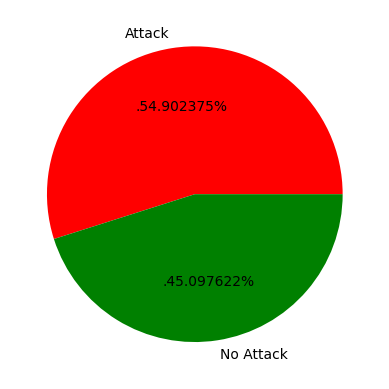

In [22]:
plt.pie(data['Target Attack'].value_counts(), labels=[ 'No Attack', 'Attack'], colors=['green', 'red'], autopct = '.%2f%%')

### 5. Data Preprocessing

In [25]:
# remove object features
data.drop(categ_cols, axis=1, inplace=True)
data.head()


,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
0,27,10,0,10,11,2.570417,6,6,7,3.666667,14,1,1
1,27,10,0,10,11,2.767195,6,6,7,3.666667,14,1,1
2,26,9,0,10,10,2.742338,6,6,7,3.500000,13,1,0
3,27,10,0,10,11,2.570417,6,6,7,3.666667,14,1,1
4,15,9,0,11,0,2.929439,4,3,5,4.333333,15,1,1


In [26]:
# remove duplicates
data.shape
data.drop_duplicates(inplace=True)
print('Shape after dropping duplicates: ', data.shape)


(268074, 13)

Shape after dropping duplicates:  (3177, 13)


([<matplotlib.patches.Wedge at 0x1669c352b80>,
 [Text(-1.0972131788757449, 0.07825113482488716, 'No Attack'),
  Text(1.0972131816231443, -0.07825109630169524, 'Attack')],
 [Text(-0.5984799157504063, 0.04268243717721117, '97.733712%'),
  Text(0.5984799172489877, -0.04268241616456104, '2.266289%')])

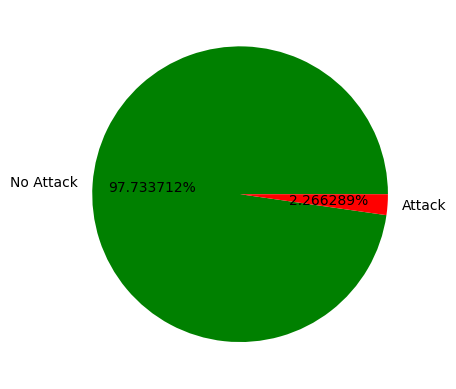

In [30]:
plt.pie(data['Target Attack'].value_counts(), labels=[ 'No Attack', 'Attack'], colors=['green', 'red'], autopct = '%2f%%')

In [28]:
data['Target Attack'].value_counts()

0    3105
1      72
Name: Target Attack, dtype: int64

<Figure size 1000x500 with 0 Axes>

<Axes: >

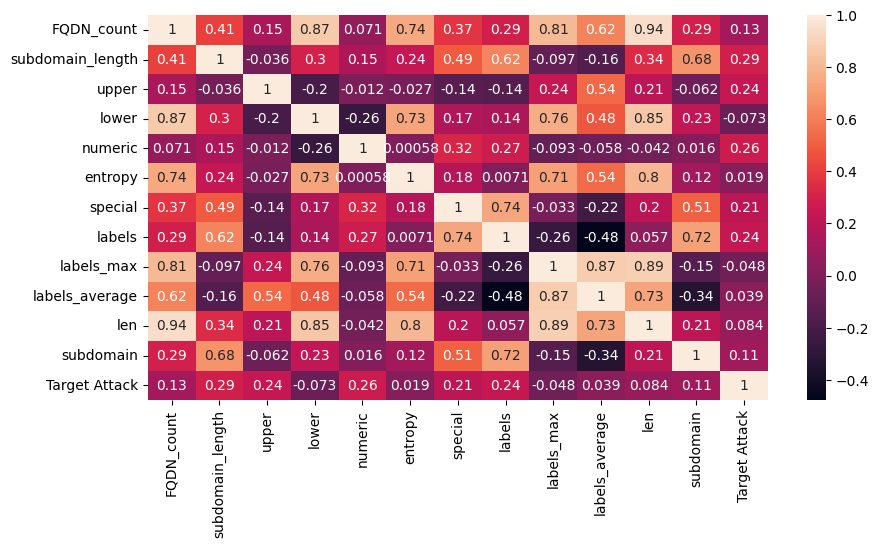

In [34]:
# Correlation and feature selection
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True)

There is multicollinearity
FDN_count - lower, entropy, labels_max, len
lower - len, labels_max, entropy, 
labels - sub_domain, special, 
labels_max - FDN_count, lower, entropy, lables_avg, len, 

<Figure size 1000x500 with 0 Axes>

<Axes: >

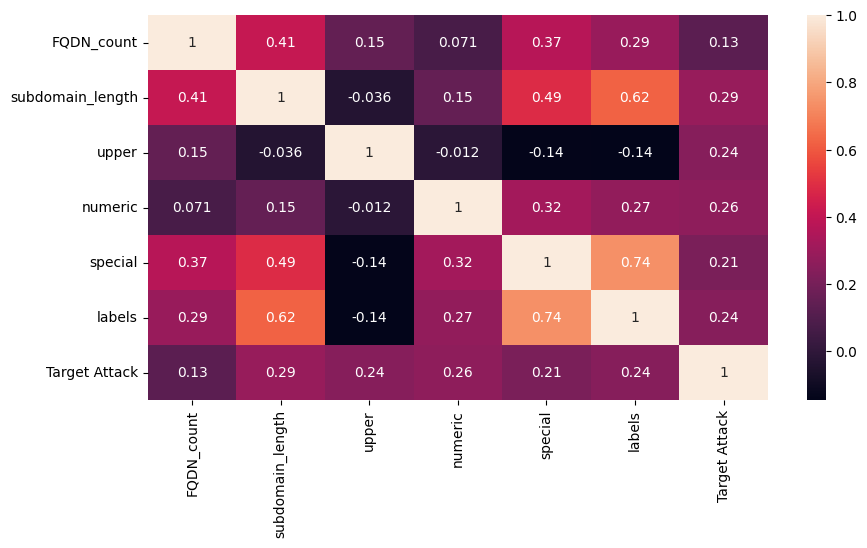

In [43]:
data_fs = data.drop(['lower', 'entropy', 'labels_average', 'len', 'labels_max', 'subdomain'], axis=1)
plt.figure(figsize=(10,5))
sns.heatmap(data_fs.corr(), annot=True)

In [44]:
data_fs.shape

(3177, 7)

In [52]:
from sklearn.model_selection import train_test_split
# train test split
y = data_fs['Target Attack']
x = data_fs.drop('Target Attack', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
(x_train.shape, y_train.shape, x_test.shape)


((2541, 6), (2541,), (636, 6))

In [55]:
# SMOTE on training data
pipe = Pipeline(steps=[('over', SMOTE(sampling_strategy=0.5)), 
                 ('onder', RandomUnderSampler(sampling_strategy=0.6))])

x_train_os, y_train_os = pipe.fit_resample(x_train, y_train)
(x_train_os.shape, y_train_os.shape)


((3309, 6), (3309,))

In [56]:
y_train_os.value_counts()

0    2068
1    1241
Name: Target Attack, dtype: int64

In [71]:
def cross_validation_score(X, Y, X_test, Y_test, models):
    model_score = {}
    test_score = {}
    for name, model in models.items():
        print("5-Fold Cross-Validation : ", name)

        model.fit(X, Y)
        model_score[name] = f1_score(Y, model.predict(X))
        
        # model_score[name] = np.mean(cross_val_score(model,X, Y,
        #                                       cv=5,
        #                                       scoring='roc_auc',
        #                                       verbose=2,
        #                                       n_jobs=-1))
        y_pred = model.predict(X_test)
        test_score[name] = f1_score(Y_test, y_pred)
        
    # Converting model_score to DataFrame
    model_score = {'F1 Score': model_score, 'Test Score': test_score}
    model_score_df = pd.DataFrame(model_score)
    model_score_df.rename_axis('Model', inplace=True)
    model_score_df.reset_index(inplace=True)
    model_score_df.sort_values('Test Score', ascending=False, inplace=True)
    return model_score_df


logreg_pipe = skPipe(steps=[('scaler', StandardScaler()),
                            ('log', LogisticRegression())])
models = {'Logistic': logreg_pipe,
          'RandomForest': RandomForestClassifier(),
          'LightGBM': LGBMClassifier(),
          'XGBoost': XGBRFClassifier()}

scores = cross_validation_score(x_train_os, y_train_os, x_test, y_test, models)
scores



5-Fold Cross-Validation :  Logistic
5-Fold Cross-Validation :  RandomForest
5-Fold Cross-Validation :  LightGBM
5-Fold Cross-Validation :  XGBoost


,Model,F1 Score,Test Score
3,XGBoost,0.920161,0.285714
2,LightGBM,0.938232,0.250000
1,RandomForest,0.940129,0.217391
0,Logistic,0.835128,0.213333


### Experimenting without dropping the duplicates

<Figure size 1000x500 with 0 Axes>

([<matplotlib.patches.Wedge at 0x166b3aa17f0>,
 [Text(-0.16874495648837814, 1.0869798248632472, 'No Attack'),
  Text(0.16874485471798156, -1.0869798406622855, 'Attack')],
 [Text(-0.09204270353911535, 0.5928980862890438, '54.902375%'),
  Text(0.09204264802798993, -0.5928980949067011, '45.097622%')])

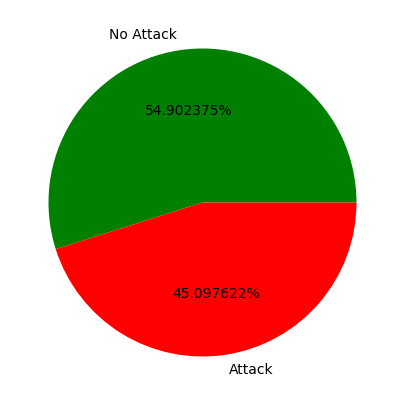

In [77]:
# Without dropping duplicates
data = pd.read_csv('Static_dataset.csv')

data.drop(categ_cols, axis=1, inplace=True)
plt.pie(data['Target Attack'].value_counts(), labels=[ 'No Attack', 'Attack'], colors=['green', 'red'], autopct = '%2f%%')

<Figure size 1000x500 with 0 Axes>

<Axes: >

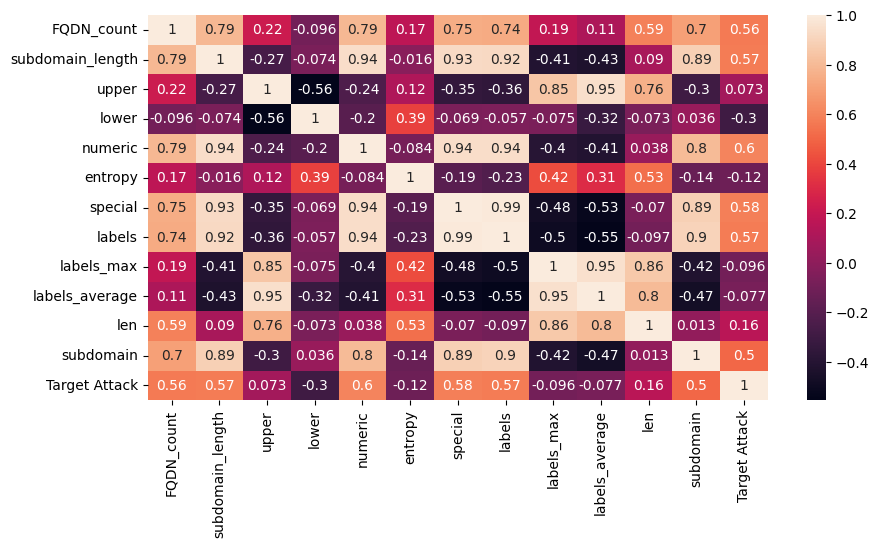

In [79]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True)

<Figure size 1000x500 with 0 Axes>

<Axes: >

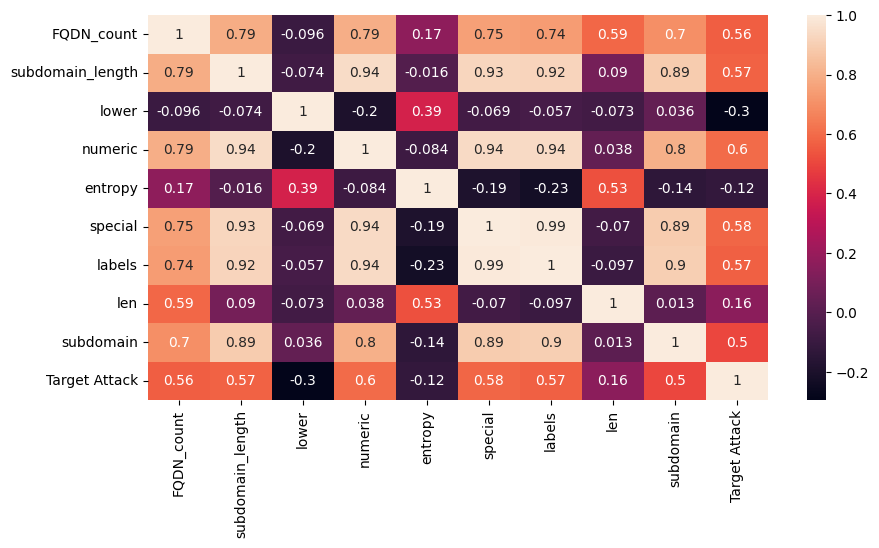

In [80]:
# Feature Selection
data_fs = data.drop(['upper', 'labels_max', 'labels_average' ], axis=1)
plt.figure(figsize=(10,5))
sns.heatmap(data_fs.corr(), annot=True)

In [81]:
data_fs['Target Attack'].value_counts()

1    147179
0    120895
Name: Target Attack, dtype: int64

In [82]:
# train test split
y = data_fs['Target Attack']
x = data_fs.drop('Target Attack', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
(x_train.shape, y_train.shape, x_test.shape)

((214459, 9), (214459,), (53615, 9))

In [86]:
def cross_validation_score(X, Y, X_test, Y_test, models):
    model_score = {}
    test_score = {}
    for name, model in models.items():
        print("5-Fold Cross-Validation : ", name)

        model.fit(X, Y)
        model_score[name] = f1_score(Y, model.predict(X))
        
        # model_score[name] = np.mean(cross_val_score(model,X, Y,
        #                                       cv=5,
        #                                       scoring='roc_auc',
        #                                       verbose=2,
        #                                       n_jobs=-1))
        y_pred = model.predict(X_test)
        test_score[name] = f1_score(Y_test, y_pred)
        
    # Converting model_score to DataFrame
    model_score = {'F1 Score': model_score, 'Test Score': test_score}
    model_score_df = pd.DataFrame(model_score)
    model_score_df.rename_axis('Model', inplace=True)
    model_score_df.reset_index(inplace=True)
    model_score_df.sort_values('Test Score', ascending=False, inplace=True)
    return model_score_df


logreg_pipe = skPipe(steps=[('scaler', StandardScaler()),
                            ('log', LogisticRegression())])
models = {'Logistic': logreg_pipe,
          'RandomForest': RandomForestClassifier(),
          'LightGBM': LGBMClassifier(),
          'XGBoost': XGBRFClassifier()}

scores = cross_validation_score(x_train, y_train, x_test, y_test, models)
scores

5-Fold Cross-Validation :  Logistic
5-Fold Cross-Validation :  RandomForest
5-Fold Cross-Validation :  LightGBM
5-Fold Cross-Validation :  XGBoost


,Model,F1 Score,Test Score
2,LightGBM,0.863007,0.864085
1,RandomForest,0.863016,0.864026
3,XGBoost,0.862839,0.863935
0,Logistic,0.861278,0.862567


In [89]:
# Saving LightGBM model
import pickle as pkl
pkl.dump(models['LightGBM'], open('LGBM_model.pkl', 'wb'))